Sources:

- https://www.kaggle.com/competitions/rsna-breast-cancer-detection/overview
- https://www.kaggle.com/datasets/radek1/rsna-mammography-images-as-pngs?select=images_as_pngs_1024

In [28]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import pathlib
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import os
import cv2
import glob
from skimage import io

from skimage import data
from skimage import filters
from skimage.color import rgb2gray
from skimage.io import imread

- site_id - ID code for the source hospital.
- patient_id - ID code for the patient.
- image_id - ID code for the image.
- laterality - Whether the image is of the left or right breast.
- view - The orientation of the image. The default for a screening exam is to capture two views per breast.
- age - The patient's age in years.
- implant - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.
- density - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult. Only provided for train.
- machine_id - An ID code for the imaging device.
- cancer - Whether or not the breast was positive for malignant cancer. The target value. Only provided for train.
- biopsy - Whether or not a follow-up biopsy was performed on the breast. Only provided for train.
- invasive - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train.
- BIRADS - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.
- prediction_id - The ID for the matching submission row. Multiple images will share the same prediction ID. Test only.
- difficult_negative_case - True if the case was unusually difficult. Only provided for train.

There are two standard views of the breast taken during mammography. Craniocaudal, or “CC view” (taken from top-down, shown on left), and mediolateral oblique, or “MLO view” (taken from the side at an angle, shown on right).

In [2]:
df = pd.read_csv("./../Datasets/RSNA_Screening_Mammography_Breast_Cancer_Detection/train.csv")
df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [9]:
df.site_id.value_counts(normalize=True) # code for the source hospital.

1    0.539593
2    0.460407
Name: site_id, dtype: float64

In [11]:
len(df.patient_id.unique())

11913

In [14]:
len(df.image_id.unique())

54706

In [19]:
df.laterality.value_counts(normalize=True)

R    0.501572
L    0.498428
Name: laterality, dtype: float64

In [20]:
df.view.value_counts(normalize=True)

MLO    0.510054
CC     0.489252
AT     0.000347
LM     0.000183
ML     0.000146
LMO    0.000018
Name: view, dtype: float64

<AxesSubplot: >

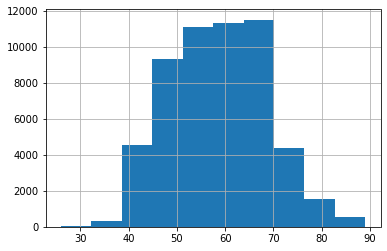

In [22]:
df.age.hist()

In [8]:
100*df.cancer.value_counts(normalize=True)

0    97.88323
1     2.11677
Name: cancer, dtype: float64

In [6]:
df.density.value_counts(normalize=True)

B    0.429284
C    0.413132
A    0.105361
D    0.052223
Name: density, dtype: float64

In [5]:
df.invasive.value_counts(normalize=True)

0    0.985047
1    0.014953
Name: invasive, dtype: float64

In [7]:
df.difficult_negative_case.value_counts(normalize=True)

False    0.859156
True     0.140844
Name: difficult_negative_case, dtype: float64

# Ejemplos

In [23]:
folder = "./../Datasets/RSNA_Screening_Mammography_Breast_Cancer_Detection/train_images_processed_1024/10006/"


In [26]:
for i in os.listdir(folder):
    print(folder+i)

./../Datasets/RSNA_Screening_Mammography_Breast_Cancer_Detection/train_images_processed_1024/10006/1874946579.png
./../Datasets/RSNA_Screening_Mammography_Breast_Cancer_Detection/train_images_processed_1024/10006/1459541791.png
./../Datasets/RSNA_Screening_Mammography_Breast_Cancer_Detection/train_images_processed_1024/10006/1864590858.png
./../Datasets/RSNA_Screening_Mammography_Breast_Cancer_Detection/train_images_processed_1024/10006/462822612.png


In [30]:
path = './../Datasets/RSNA_Screening_Mammography_Breast_Cancer_Detection/train_images_processed_1024/'
data_dir = pathlib.Path(path)
imageCount = len(list(data_dir.glob('*/*.png')))
imageCount

20222

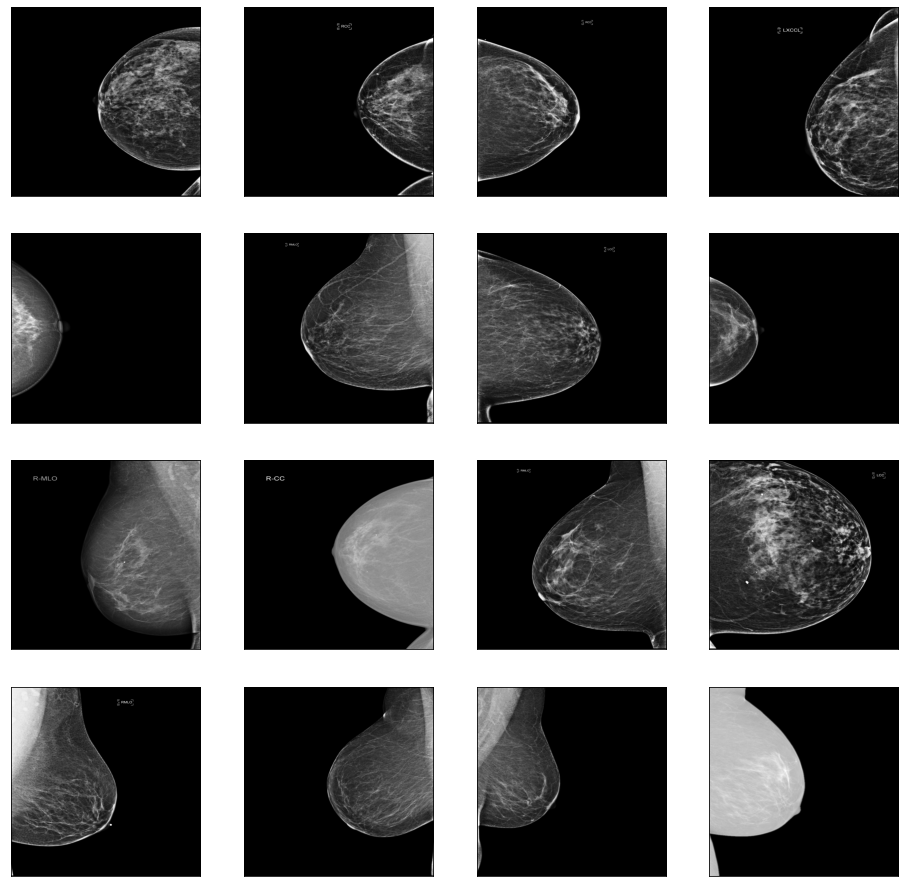

In [38]:
plt.figure(figsize=(16,16))

for i in range(16):
    plt.subplot(4,4,i+1)
    img = plt.imread(random.choice(list(data_dir.glob('*/*.png'))))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')